# **MACHINE LEARNING 1 PROJECT**

## **ANAGHA ASHOK**

## **21BDA50**



In [1]:
#We can use the magic function %matplotlib inline to enable the inline plotting.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd

#To load the image, we simply import the image module from the pillow and call the Image. 
from PIL import Image

#tqdm is a Python library that allows you to output a smart progress bar by wrapping around any iterable.
#A tqdm progress bar not only shows you how much time has elapsed, but also shows the estimated time remaining for the iterable.
from tqdm import tqdm

In [2]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv",index_col="id")

In [3]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

<font size="5">**3.SPITTING INTO TRAIN AND EVALUATION SETS**</font>

**First, we'll need to split the images into train and evaluation sets.**

In [4]:
from sklearn.model_selection import train_test_split

frac = 0.5

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [5]:
x_train.head()

,filepath
id,
ZJ008117,train_features/ZJ008117.jpg
ZJ016163,train_features/ZJ016163.jpg
ZJ014803,train_features/ZJ014803.jpg
ZJ012302,train_features/ZJ012302.jpg
ZJ008816,train_features/ZJ008816.jpg


In [6]:
y_train.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ008117,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZJ016163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ZJ014803,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZJ012302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ZJ008816,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((6183, 1), (6183, 8), (2061, 1), (2061, 8))

In [8]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
monkey_prosimian,15,15
antelope_duiker,14,14
civet_genet,14,14
blank,13,13
leopard,13,13
rodent,11,11
bird,9,9
hog,5,5


<font size="5">**4. Build the Model**</font>

<font size="3">First, we'll create an ImagesDataset class that will define how we access our data and any transformations we might want to apply.

This new class will inherit from the PyTorch Dataset class, but we'll also need to define our own __init__, __len__ and __getitem__ special methods:

->  __init__ will instantiate the dataset object with two dataframes: an x_train df containing image IDs and image file paths,       and a y_train df containing image IDs and labels. This will run once when we first create the dataset object

->  __getitem__ will define how we access a sample from the data. This method gets called whenever we use an indexing operation      like dataset[index]. In this case, whenever accessing a particular image sample ,the following will happen:
    
           look up the image filepath using the index
    
           load the image with PIL.Image
    
           apply some transformations 
    
           return a dictionary containing the image ID, the image itself as a Tensor, and a label 
    
->  __len__ simply returns the size of the dataset, which we do by calling len on the input dataframe.
    </font>

**Setting up environment**

In [10]:
!conda create -n conserviz python=3.8

^C


In [ ]:
conda activate conserviz
pip install pandas matplotlib Pillow tqdm scikit-learn torch torchvision

In [11]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

<font size="3"> Here we are also defining a set of transformations, which are defined in the __init__ and called in the __getitem__ special methods.</font>
    
    ->transforms.Resize((224, 224)) ResNet50 was trained on images of size 224x224 so we resize to the same dimensions here.
    
    ->transforms.ToTensor() converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can             recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of       [0, 1].
    
    ->transforms.Normalize(...) normalizes the image tensors using the mean and standard deviation of ImageNet images.

<font size="3">**DataLoader**
    
Next, we need to load the dataset into a dataloader. The DataLoader class lets us iterate through our dataset in batches.</font>

In [12]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [9]:
pip install -r requirements.txt

<font size="5">**5. Training**</font>
    
<font size="3">Now it's time to start building our model and then training it.

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between.
    </font>

In [13]:
from torch import nn
import torchvision.models as models


model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  
    nn.ReLU(inplace=True),  
    nn.Dropout(0.1),  
    nn.Linear(
        100, 8
    ),  
)

<font size="3">**Define loss function**

Cross entropy loss is a commonly used loss function for multi-class image classification.

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

<font size="3">**Train the model**

In [15]:
num_epochs = 1

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        
        optimizer.zero_grad()

        outputs = model(batch["image"])

        #  compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        loss.backward()
        optimizer.step()

Starting epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [21:45<00:00,  6.73s/it]


<font size="3">let's plot the loss by epoch and batch. The x-axis here is a tuple of (epoch, batch).</font>

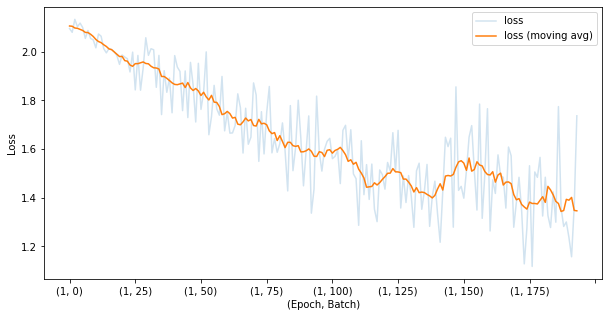

In [16]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

<font size="3">The loss is going down!</font> 

# **6. Evaluation**

In [17]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

<font size="4">**Prediction**</font>

In [18]:
preds_collector = []


model.eval()

with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        logits = model.forward(batch["image"])
        preds = nn.functional.softmax(logits, dim=1)
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [02:34<00:00,  2.38s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ012915,0.148916,0.088575,0.203110,0.012492,0.060617,0.146043,0.263903,0.076344
ZJ016034,0.169198,0.172712,0.111106,0.003768,0.024079,0.027059,0.458105,0.033972
ZJ014621,0.176485,0.135707,0.120379,0.004067,0.021517,0.044098,0.454415,0.043331
ZJ008027,0.189409,0.143649,0.187426,0.008509,0.034638,0.139923,0.249696,0.046750
ZJ009592,0.032543,0.009745,0.134855,0.031898,0.098814,0.643281,0.011558,0.037306
...,...,...,...,...,...,...,...,...
ZJ009639,0.199200,0.140994,0.153460,0.032299,0.065050,0.071191,0.202693,0.135114
ZJ000223,0.196555,0.135938,0.152198,0.018078,0.061357,0.079961,0.250054,0.105859
ZJ010408,0.066515,0.014857,0.213894,0.160153,0.078877,0.117694,0.016898,0.331112
ZJ002593,0.014152,0.001528,0.013647,0.830339,0.012361,0.007726,0.001204,0.119043


In [19]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    973
antelope_duiker     925
civet_genet         896
blank               860
leopard             841
rodent              732
bird                608
hog                 348
dtype: int64

 **The distribution of  predictions on the eval set.**

In [20]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    950
rodent              336
civet_genet         310
leopard             307
blank                78
antelope_duiker      69
bird                 10
hog                   1
dtype: int64

**The actual evaluation set is more evenly distributed than our predictions**

In [21]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    325
antelope_duiker     308
civet_genet         298
blank               287
leopard             280
rodent              244
bird                203
hog                 116
dtype: int64

## **Accuracy**

In [23]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions

ZJ012915    monkey_prosimian
ZJ016034    monkey_prosimian
ZJ014621    monkey_prosimian
ZJ008027    monkey_prosimian
ZJ009592             leopard
                  ...       
ZJ009639    monkey_prosimian
ZJ000223    monkey_prosimian
ZJ010408              rodent
ZJ002593         civet_genet
ZJ005840    monkey_prosimian
Length: 2061, dtype: object

In [24]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.1576904415332363

In [25]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.4949053857350801

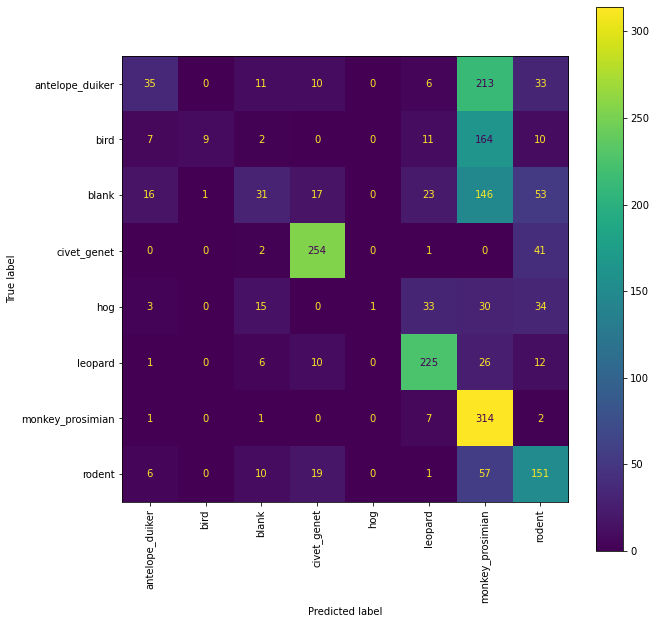

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

## **RESULT**

<font size="3">**1. Our accuracy on the evaluation set is about 50%, which is not a bad start for a very simple first pass and one epoch of training.**</font>

<font size="3">**2.We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.**</font>









# CONCLUSION

* <font size="3">**Train on the full training dataset. We've only used 50% of the training data so far.**
* **Train for more epochs. We've only done 1 so far.**
* **We can also try another pretrained model like  with EfficientNet, or another ResNet model with more layers like ResNet152,we     may get better accuracy.**</font>